#### Setup
The data is set up, split, and pre-processed using the same process as before. 

In [1]:
import nltk
import time
import eli5
import string
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

from eli5.lime import TextExplainer
from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords 
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, sent_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer 

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score,f1_score, classification_report

sns.set_style("whitegrid")
sns.set_palette("rocket")

warnings.simplefilter(action='ignore')

In [2]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/lois/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lois/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lois/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
#load in data
suicide = pd.read_csv("/Users/Lois/Downloads/ML ipynb/Capstone/SuicideDetection.csv")
suicide = suicide.sample(20000, random_state = 42)

In [4]:
#only keeping the text and class columns
suicide.drop("Unnamed: 0", axis = 1, inplace = True)

#renaming "class" column as "suicide"
suicide.rename({"class" : "suicide"}, axis = 1, inplace = True)

#numerically representing the contents of "suicide" column
suicide.replace({"suicide" : 1, "non-suicide" : 0}, inplace = True)
suicide.head()

,text,suicide
74414,I Don't know?7? Months self harm free and the ...,1
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,0
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",0
14043,I've honestly got no idea what to do anymore.I...,1
30673,Do you ever just cry? Like you just think abou...,0


In [5]:
#train test split
X = suicide['text']
y = suicide['suicide']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [6]:
#tokenization, stop word removal, punctuation removal, lower casing, and stemming
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case = False)
    swords = stopwords.words('english')
    punc = list(string.punctuation)
    stemmer = PorterStemmer()
    
    proprocessed_text = []
    for entry in text:
        tokens = tokenizer.tokenize(entry)
        proprocessed_text.append([stemmer.stem(word) for word in tokens if word not in swords and word not in punc])
    return proprocessed_text

In [7]:
#preprocessing
pX_train = preprocess_text(X_train)
pX_train = [' '.join(x) for x in pX_train]

pX_test = preprocess_text(X_test)
pX_test = [' '.join(x) for x in pX_test]

In [8]:
#adding a column of preprocessed text to the df
suicide['pX'] = preprocess_text(X)

In [9]:
#updated df 
suicide.head()

,text,suicide,pX
74414,I Don't know?7? Months self harm free and the ...,1,"[know, 7, month, self, harm, free, urg, get, s..."
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,0,"[start, becom, rich, start, compani, becom, 16..."
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",0,"[poem, haiku, u, me-game-dev, hi, hello, hello..."
14043,I've honestly got no idea what to do anymore.I...,1,"[i'v, honestli, got, idea, anymore.it, feel, e..."
30673,Do you ever just cry? Like you just think abou...,0,"[ever, cri, like, think, unfair, life, cri, ca..."


#### Model Evaluation 

We begin by re-fitting the optimal SVC model using results of RandomizedSearchCV.

In [17]:
#re-fitting model
vec = TfidfVectorizer()
svc = SVC(kernel = 'linear', probability = True, C = 1)

svc_pipe = Pipeline([
    ('tfidf', vec),
    ('svc', svc)
]).fit(pX_train, y_train)

##### Model Stats

This model has an accuracy of 0.924, a recall of 0.98, and an f1-score of 0.92.

In [19]:
y_pred = svc_pipe.predict(pX_test)
print(classification_report(y_test, y_pred))
print("accuracy: {:0.3f}".format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      2487
           1       0.93      0.92      0.92      2513

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000

accuracy: 0.924


#### Model Testing

We will using this model to predict individual posts by passing in the text of a single entry from the data, then comparing the model's predicted class and the actual class. This model correctly predicts the class of the first two data points, which are, respectively, non-suicidal and suicidal. Recall that 0 = not suicidal and 1 = suicidal.

**Example prediction of a non-suicidal post**



In [20]:
#example prediction of the first datapoint
y_pred0 = svc_pipe.predict(pX_test)[0]
print(f'Predicted class: {y_pred0} \nActual class: {y_test.iloc[0]} \nPost: {X_test.iloc[0]}')

Predicted class: 0 
Actual class: 0 
Post: A teenage love story. So it all started in 2nd grade. I really liked that one girl in my class (let's call her Sara for sake of privacy) and never knew how to tell her. 

Fast forward to 3rd grade and our teacher was pissed at our class so she decided to rearrange our seats, now... take a hot guess, who was chosen to seat with me. If you guessed Sara, you were right.

We started getting along, having fun on lessons and lunch breaks. We were best friends.

Fast forward again now to 4th grade. All the classes were mixed and we sadly weren't in the same one. We still hung out and stuff but didn't have as much time for each other as before. Year 2016, February 14th, Valentines day. "It's my chance!" so since we didn't finish lessons at the same time I gave my close friend a letter from me to give to her after school. He gave it to her. Same day, just after class, she messages me and tells me she had a big crush on me since 1st grade "The fuck!?" w

**Example prediction of a suicidal post**

In [21]:
y_pred1 = svc_pipe.predict(pX_test)[1]
print(f'Predicted class: {y_pred1} \nActual class: {y_test.iloc[1]} \nPost: {X_test.iloc[1]}')

Predicted class: 1 
Actual class: 1 
Post: I don't want to feel this way.I just want to get my meds straightened out and be happy. I don't want to feel sad, worthless, or like life is pointless. I want to enjoy life again and feel like others love me. 

I just need someone to tell me that it'll all get straightened out and I'll be happy again. I really need some one to reassure me because it all feels so bleak. I'm sorry. 


#### Model Evaluation

Now that we've ascertained our model's capacity to correctly classify social media posts as suicidal, we will move on to interpret the features of the model and of the data that facilitate this performance. There are two general ways to evaluate a classification model; they are looking at the global (model) vs local (individual) feature importances. A global analysis is concerned with identifying the weights the model as a whole assigns individual features, while a local analysis looks at the features used in making an individual prediction. 

We begin with a global analysis of the optimal SVC model by using the eli5 library.  

**Model Weights** 

The eli5.show_weights() function displays what the model learned by showing the feature (word) weights it assigned. For our SVC pipeline model, the following words are the top fifteen features the classifier used to correctly identify suicidality in a post (i.e. y = 1). Stemmed words with a weight over 3.0 are, in descending order, ["suicid", "kill", "end", "pill", "life", "die"]. 

In [24]:
#model's most important features
eli5.show_weights(svc_pipe, vec = vec, top=15, target_names = y_test)

Weight?,Feature
+7.969,suicid
+5.339,kill
+3.849,end
+3.259,pill
+3.131,life
+3.015,die
+2.878,live
+2.768,hang
+2.659,anymor
+2.657,overdos


**Feature importance in individual predictions**

We continue with a local analysis of a prediction for a suicidal post and a non-suicidal post (class = 0). eli5.lime.TextExplainer is used to demarcate the prediction of individual data points. Each TextExplainer instance shows the salient features (in green gradient) for predicting the class of a particular document. A red highlight indicates a negative feature importance, meaning that the word reduces the prediction value and increases the loss. 

**Example non-suicidal post**

The following is the prediction made for a non-suicidal post. We can see that the five most important words (indicated by the green saturation level) are roughly, in order, ["lol", "weird", "fun", "play", "ig"]. The five least helpful features are ["feel", "guitar", "bleed", "long", "numb"]. 

In [72]:
te = TextExplainer(random_state = 42)
te.fit(pX_test[3], svc_pipe.predict_proba)
te.show_prediction()

**Example suicidal post**

The following shows the prediction made for a suicidal post (class = 1). The five most important words are ["life", "worthless", "it", "feel", "sorri"] while the five least helpful features are ["straighten", "bleak", "like", "happi", "sad"]. 

In [73]:
te = TextExplainer(random_state = 42)
te.fit(pX_test[1], svc_pipe.predict_proba)
te.show_prediction()

#### Querying

Interestingly, the word "feel" has a positive importance in determining suicidality but a negative importance in determining non-suicidality. This gives way to a theory that the absense of certain words from a post can be used to gauge the non-status of a post from a class. This concept is straightforward with a binary classification problem where it is impossible for a person/post to be both suicidal and non-suicidal. To go through each individual post and identify the absenses of certain words - which we can count as synonymous with a negative feature importance score - would be tedious. As such, we will make use of the query operator to find if, perhaps, 

Assuming there are words in our 20,000 size sample where strictly no overlap exists. A statistical survey would be ideal. 

#### Class Features Overview 

We begin by compiling two vocabularies, the first composed of every unique word from the suicidal class and the second composed of every unique word from the non-suicidal class. We are looking for words that appear in one class and not the other and cross-checking this list with the permutation importance scores assigned by our SVC model.

In [127]:
#collecting words in the posts of each class
suicide_words = suicide[suicide['suicide'] == 1]['pX'].values
non_suicide_words = suicide[suicide['suicide'] == 0]['pX'].values

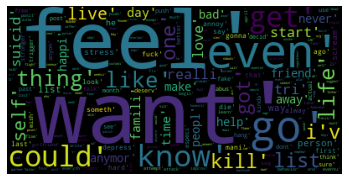

In [128]:
#suicide word cloud 
s_wordcloud = WordCloud(stopwords = STOPWORDS).generate(str(suicide_words))
plt.imshow(s_wordcloud)
plt.axis('off')
plt.show()

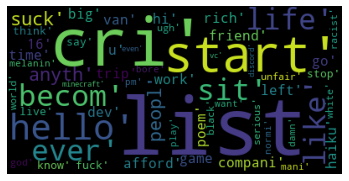

In [129]:
#non-suicide word cloud 
x_wordcloud = WordCloud(stopwords = STOPWORDS).generate(str(non_suicide_words))
plt.imshow(x_wordcloud)
plt.axis('off')
plt.show()


and explore ways to improve it